In [6]:
# Required to correctly display interactive (dynamic) plots in Jupyter notebooks.
# This code cell must be run before any other code cell.
%matplotlib notebook

# Generic imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# `scikit-multiflow` tutorial

This tutorial is divided into the follwing parts:

**PART I.Design and run experiments**
1. Classification task examples
  1. Prequential evaluation implementation
  2. The `EvaluatePrequential` class

2. Concept drift detection
  1. Drift detection test
  2. Impact on predictive performance

3. Regression task examples

**PART II. Extend functionality**
4. Implement a simple estimator
  
---

# PART I. Design and run experiments

## 1. Classification task examples

In this example we will use the `SEA` stream generator. A data generator does not store any data, but generates it on demand.

Next we will setup a learning method (model, estimator, algorithm), in this case the Naive Bayes classifier:

In [7]:
from skmultiflow.data import SEAGenerator
from skmultiflow.bayes import NaiveBayes

stream = SEAGenerator(random_state=1)
classifier = NaiveBayes()

### Prequential evaluation

The prequentail evaluation is easily implemented as a loop:

In [8]:
# Variables to control evaluation loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 2000

# Prequential evaluation loop
while n_samples < max_samples and stream.has_more_samples():
   X, y = stream.next_sample()      # Get one sample from the stream
   y_pred = classifier.predict(X)   # Predict class for new data
   if y[0] == y_pred[0]:
       correct_cnt += 1
   classifier.partial_fit(X, y)     # Incrementally train the model with the new data
   n_samples += 1

print('{} samples analyzed.'.format(n_samples))   
print('NaiveBayes classifier accuracy: {}'.format(correct_cnt / n_samples))

2000 samples analyzed.
NaiveBayes classifier accuracy: 0.9395


### `EvaluatePrequential` class

Implements the prequential evaluation method and provides extra functionalities.

Let's run the same experiment on the SEA data but this time we will compare two classifiers:

1. `NaiveBayes`
2. `SGDClassifier`: Linear SVM with SGD training.

We choose the `SGDClassifier` in order to demonstrate the compatibility with incremental methods from `scikit-learn`.

**Note:** `scikit-learn` focuses on the batch learing setting and only a **limited** number of its methods are capable to learn incrementally.

In [9]:
from skmultiflow.evaluation import EvaluatePrequential
from sklearn.linear_model import SGDClassifier

# Setup stream and estimators
stream = SEAGenerator(random_state=1)
nb = NaiveBayes()
svm = SGDClassifier()

# Setup evaluator
eval = EvaluatePrequential(show_plot=True,
                           max_samples=20000,
                           metrics=['accuracy', 'kappa', 'running_time', 'model_size'])

<IPython.core.display.Javascript object>


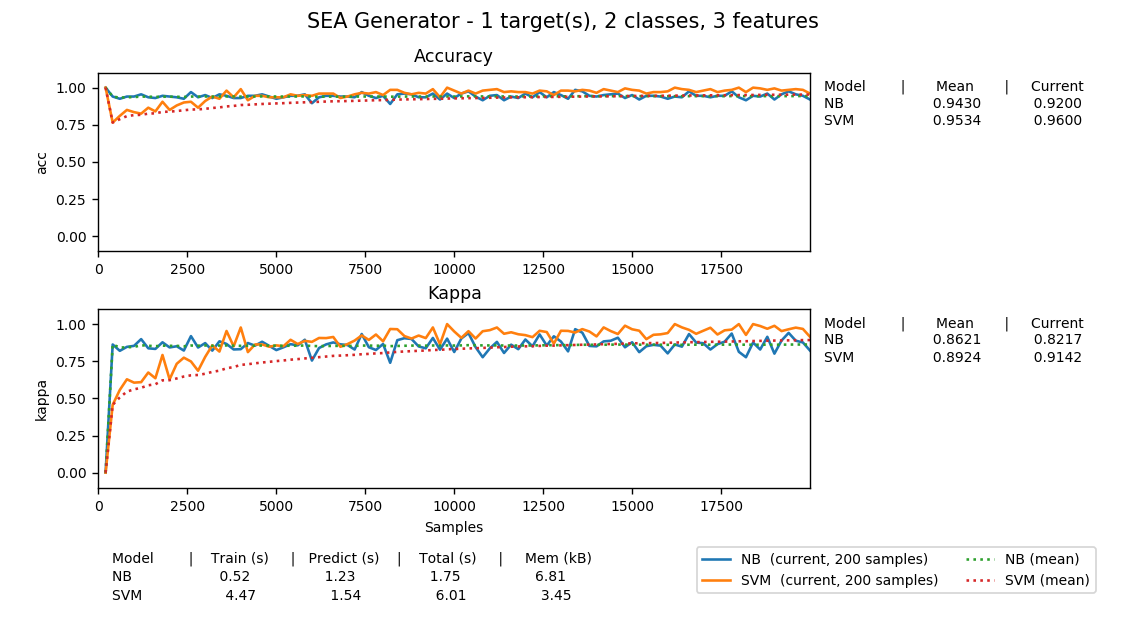

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [10.30s]
Processed samples: 20000
Mean performance:
NB - Accuracy     : 0.9430
NB - Kappa        : 0.8621
NB - Training time (s)  : 0.52
NB - Testing time  (s)  : 1.23
NB - Total time    (s)  : 1.75
NB - Size (kB)          : 6.8076
SVM - Accuracy     : 0.9534
SVM - Kappa        : 0.8924
SVM - Training time (s)  : 4.47
SVM - Testing time  (s)  : 1.54
SVM - Total time    (s)  : 6.01
SVM - Size (kB)          : 3.4531


In [10]:
# Run the evaluation
eval.evaluate(stream=stream, model=[nb, svm], model_names=['NB', 'SVM']);

---
## 2. Concept Drift

#### Simulate a data stream with concept drift

For this example, we will generate a synthetic data stream by concatenating 3 distributions of 1000 samples each:
- $dist_a$: $\mu=0.8$, $\sigma=0.05$
- $dist_b$: $\mu=0.4$, $\sigma=0.02$
- $dist_c$: $\mu=0.6$, $\sigma=0.1$.

<IPython.core.display.Javascript object>


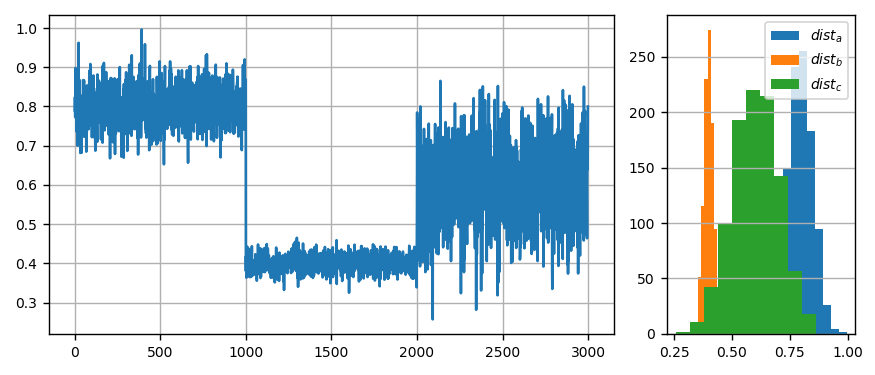

In [11]:
random_state = np.random.RandomState(12345)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

stream = np.concatenate((dist_a, dist_b, dist_c))

# Plot the data
fig = plt.figure(figsize=(7,3), tight_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
ax1.grid()
ax1.plot(stream, label='Stream')
ax2.grid(axis='y')
ax2.hist(dist_a, label=r'$dist_a$')
ax2.hist(dist_b, label=r'$dist_b$')
ax2.hist(dist_c, label=r'$dist_c$')
plt.legend()
plt.show()

### Drift detection test

In this example we will use the ADaptive WINdowing (`ADWIN`) drift detection method.

The goal is to detect that drift has occurred, after samples **1000** and **2000** in the synthetic data stream.

In [12]:
from skmultiflow.drift_detection import ADWIN

# Instantiate the ADWIN drift detector
drift_detector = ADWIN()
drifts = []

# Drift detection test
for i, val in enumerate(stream):
    drift_detector.add_element(val)        # Data is processed one sample at a time
    if drift_detector.detected_change():
        print('Change detected at index {}'.format(i))
        drift_detector.reset()
        drifts.append(i)

Change detected at index 1055
Change detected at index 2079


<IPython.core.display.Javascript object>


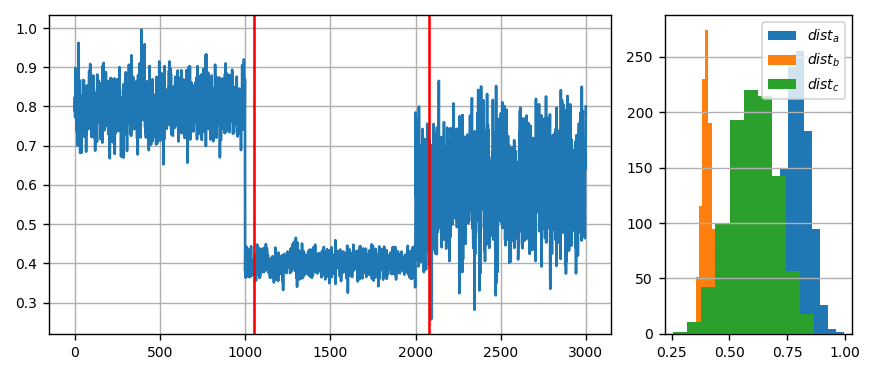

In [13]:
# Plot the data and the detected drifts
fig = plt.figure(figsize=(7,3), tight_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
ax1.grid()
ax1.plot(stream, label='Stream')
for d in drifts:
    ax1.axvline(d, color='red')
ax2.grid(axis='y')
ax2.hist(dist_a, label=r'$dist_a$')
ax2.hist(dist_b, label=r'$dist_b$')
ax2.hist(dist_c, label=r'$dist_c$')
plt.legend()
plt.show()

### Impact on predictive performance

In this example we will use two popular stream models:

1. The `Hoeffding Tree` is a type of decision tree designed for data streams.
2. The `Hoeffding Adaptive Tree` is an improvement over the original `Hoeffding Tree`.

The `Hoeffding Adaptive Tree` uses `ADWIN` to detect changes, if a change is detected at a given branch, an alternate branch is created and eventually replaces the original branch if it shows better performance on new data.

For this example we will load the data from a csv file using the `FileStream` class.

The data corresponds to the output of the `AGRAWALGenerator` with 3 **gradual drifts** at the 5k, 10k and 15k marks.

#### AGRAWAL data generator

The generator produces a stream containing 9 features, 6 numeric and 3 categorical.
 
There are 10 functions for generating binary class labels from the features. These fnctions determine whether a loan should be approved.

| Feature    | Description            | Values                                                                |
|------------|------------------------|-----------------------------------------------------------------------|
| salary     | the salary             | uniformly   distributed from 20k to 150k                              |
| commission | the commission         | if (salary <   75k) then 0 else uniformly distributed from 10k to 75k |
| age        | the age                | uniformly   distributed from 20 to 80                                 |
| elevel     | the education   level  | uniformly   chosen from 0 to 4                                        |
| car        | car maker              | uniformly   chosen from 1 to 20                                       |
| zipcode    | zip code of the   town | uniformly   chosen from 0 to 8                                        |
| hvalue     | value of the   house   | uniformly   distributed from 50k x zipcode to 100k x zipcode          |
| hyears     | years house   owned    | uniformly   distributed from 1 to 30                                  |
| loan       | total loan   amount    | uniformly   distributed from 0 to 500k                                |

In [14]:
from skmultiflow.data import FileStream
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier

# Load data
stream = FileStream("data/agr_a_20k.csv")
# Setup estimators
cfiers = [HoeffdingTreeClassifier(), HoeffdingAdaptiveTreeClassifier()]

Setup and run the evaluation

<IPython.core.display.Javascript object>


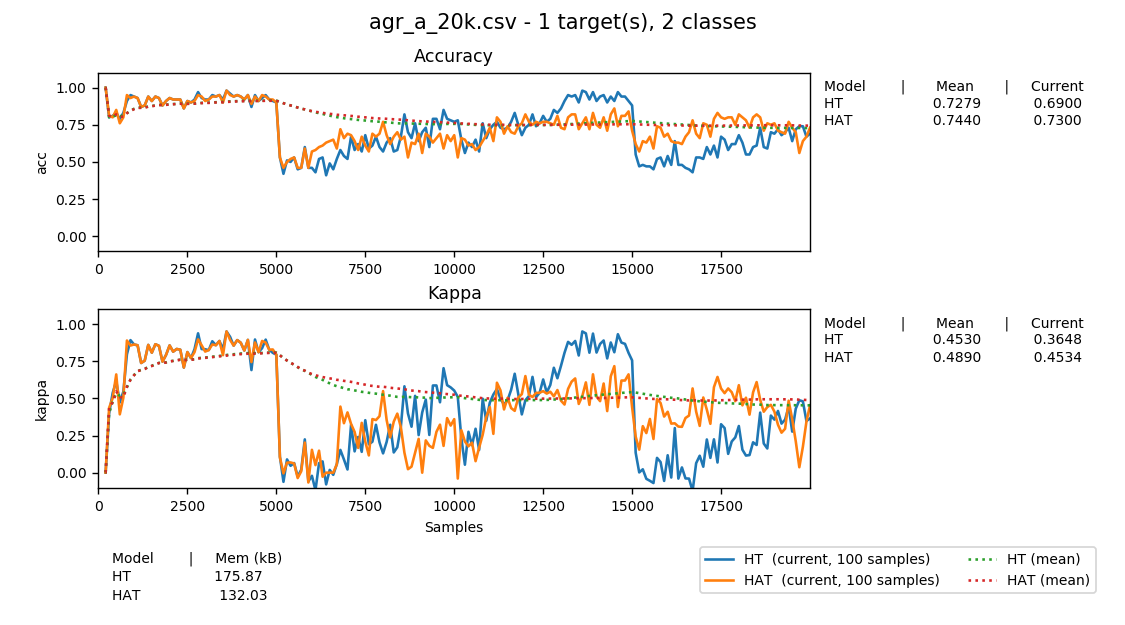

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [21.92s]
Processed samples: 20000
Mean performance:
HT - Accuracy     : 0.7279
HT - Kappa        : 0.4530
HT - Size (kB)          : 175.8711
HAT - Accuracy     : 0.7440
HAT - Kappa        : 0.4890
HAT - Size (kB)          : 132.0322


In [15]:
eval = EvaluatePrequential(show_plot=True,
                           metrics=['accuracy', 'kappa', 'model_size'],
                           n_wait=100)
eval.evaluate(stream=stream, model=cfiers, model_names=['HT', 'HAT']);

---
## 3. Regression examples

### Data sets

|          Dataset         | Samples | Attributes |
|:------------------------:|:-------:|:----------:|
|           bike           |  17389  |     16     |
| metro_interstate_traffic |  48204  |      9     |

#### Bike Sharing Dataset Data Set

Contains the **hourly and daily count of rental bikes** between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. Attributes include weather, temperature, date, time, etc.

|      Attribute      | Description |
|:-------------------:|:-----------------------------------------------------------------|
| instant             | record index
| dteday              |  date
| season              |  season (1:winter, 2:spring, 3:summer, 4:fall)
| yr                  |  year (0: 2011, 1:2012)
| mnth                |  month ( 1 to 12)
| hr                  |  hour (0 to 23)
| holiday             |  weather day is holiday or not (extracted from [Web Link])
| weekday             |  day of the week
| workingday          |  if day is neither weekend nor holiday is 1, otherwise is 0.
| weathersit          | 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
| temp                | Normalized temperature in Celsius.
| atemp               | Normalized feeling temperature in Celsius.
| hum                 | Normalized humidity.
| windspeed           | Normalized wind speed.
| casual              | count of casual users
| registered          | count of registered users
| **cnt**             | count of total rental bikes including both casual and registered

In [16]:
bike_stream = FileStream('data/bike.csv')

#### Metro Interstate Traffic Volume Data Set

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. **Hourly weather features and holidays included for impacts on traffic volume.**

|      Attribute      | Description |
|:-------------------:|:-----------------------------------------------------------------|
| holiday             | US National holidays plus regional holiday, Minnesota State Fair |
| temp                | temp in kelvin                                                   |
| rain_1h             | Amount in mm of rain that occurred in the hour                   |
| snow_1h             | Amount in mm of snow that occurred in the hour                   |
| clouds_all          | Percentage of cloud cover                                        |
| weather_main        | Short textual description of the current weather                 |
| weather_description | Longer textual description of the current weather                |
| date_time           | Hour of the data collected in local CST time                     |
| **traffic_volume**  | Hourly I-94 ATR 301 reported westbound traffic volume            |

In [17]:
traffic_stream = FileStream('data/metro_interstate_traffic.csv')

### Regression models

In this example we will use the regression variants of two popular algorithms:
* kNN Regressor
* Hoeffding Tree Regressor

In [18]:
from skmultiflow.lazy import KNNRegressor
from skmultiflow.trees import HoeffdingTreeRegressor

# Setup estimators
knn_r = KNNRegressor()
ht_r = HoeffdingTreeRegressor(leaf_prediction='mean')
# Setup evaluation
evaluator = EvaluatePrequential(show_plot=True,
                                metrics=['mean_absolute_error', 'mean_square_error', 'running_time' , 'model_size'])

<IPython.core.display.Javascript object>


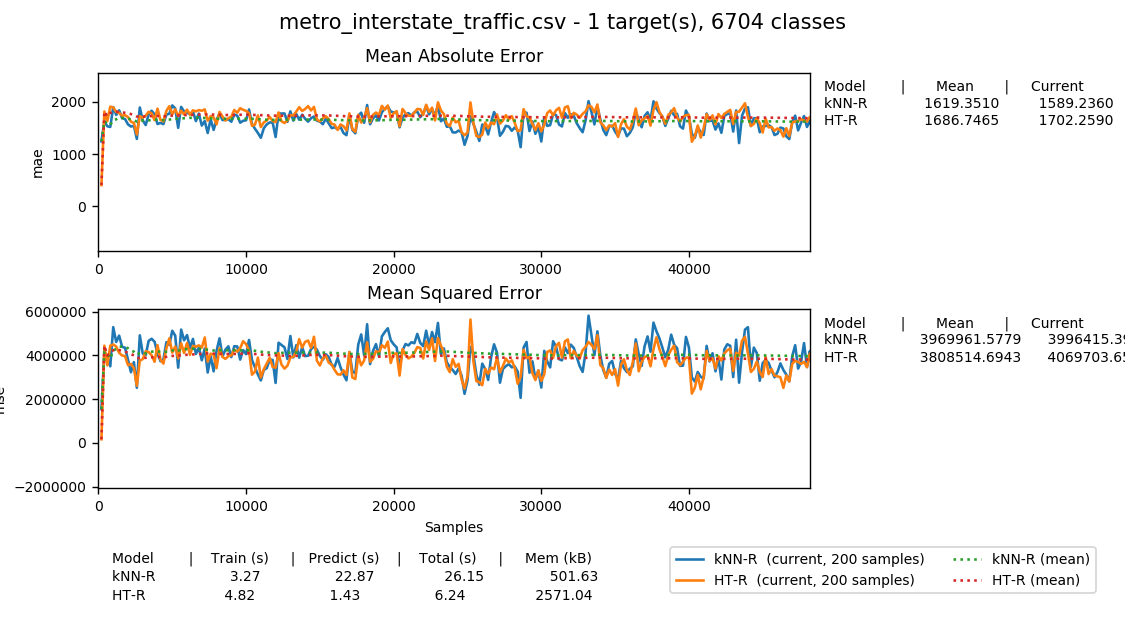

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [51.73s]
Processed samples: 48204
Mean performance:
kNN-R - MSE          : 3969961.5779
kNN-R - MAE          : 1619.350987
kNN-R - Training time (s)  : 3.27
kNN-R - Testing time  (s)  : 22.87
kNN-R - Total time    (s)  : 26.15
kNN-R - Size (kB)          : 501.6328
HT-R - MSE          : 3808514.6943
HT-R - MAE          : 1686.746452
HT-R - Training time (s)  : 4.82
HT-R - Testing time  (s)  : 1.43
HT-R - Total time    (s)  : 6.24
HT-R - Size (kB)          : 2571.0371


In [19]:
stream = traffic_stream

evaluator.evaluate(stream=stream, model=[knn_r, ht_r], model_names=['kNN-R', 'HT-R'])

# Restart stream and reset models for next experiment
stream.restart()
knn_r.reset()
ht_r.reset();

---
# PART II. Extend functionality

## 4. Implement a simple estimator


A core design element in `scikit-multiflow` is that it should be easy to create new methods or extend existing ones.

In the following example we show how to implement the `MajorityClassClassifier`.

The Majority Class is one of the simplest classifiers: it predicts the class of a new sample to be the most frequent at that point in the stream. It is used mostly as a baseline, but also as a default classifier at the leaves of decision trees.

In [22]:
from skmultiflow.core import BaseSKMObject, ClassifierMixin
from collections import defaultdict

class MajorityClassClassifier(BaseSKMObject, ClassifierMixin):
    def __init__(self):
        self._counts = defaultdict(int)
        self._majority = None
    
    def partial_fit(self, X, y, classes=None, sample_weight=None):
        self._counts[y[0]] += 1
        if self._majority is None:
            self._majority = y
        if self._counts[self._majority[0]] < self._counts[y[0]]:
            self._majority = y

    def predict(self, X):
        if self._majority is None:
            return np.asarray([0])
        return self._majority

    def predict_proba(self, X):
        raise NotImplementedError

In [23]:
# Setup stream and estimators
stream = SEAGenerator(random_state=1)
nb = NaiveBayes()
mc = MajorityClassClassifier()

# Setup evaluator
eval = EvaluatePrequential(show_plot=True,
                           max_samples=20000,
                           metrics=['accuracy', 'kappa', 'running_time', 'model_size'])

<IPython.core.display.Javascript object>


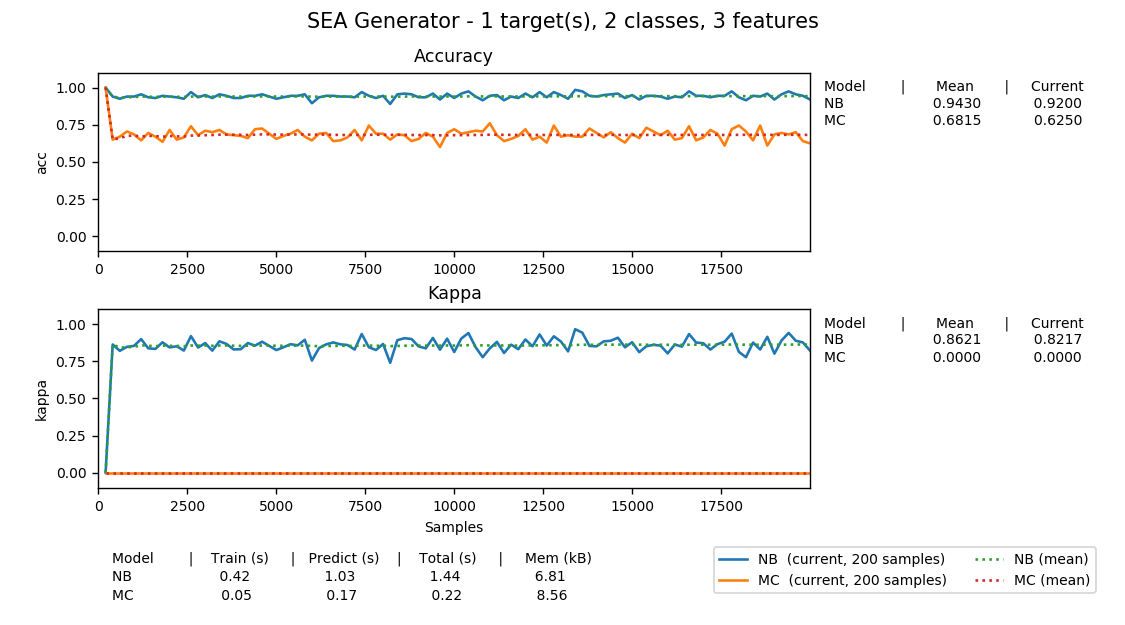

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [4.24s]
Processed samples: 20000
Mean performance:
NB - Accuracy     : 0.9430
NB - Kappa        : 0.8621
NB - Training time (s)  : 0.42
NB - Testing time  (s)  : 1.03
NB - Total time    (s)  : 1.44
NB - Size (kB)          : 6.8076
MC - Accuracy     : 0.6815
MC - Kappa        : 0.0000
MC - Training time (s)  : 0.05
MC - Testing time  (s)  : 0.17
MC - Total time    (s)  : 0.22
MC - Size (kB)          : 8.5645


In [24]:
# Run the evaluation
eval.evaluate(stream=stream, model=[nb, mc], model_names=['NB', 'MC']);